In [1]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.units as u
from astropy.table import Table, vstack
import astropy
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord
import getpass

import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
from lsst.daf.butler import Butler
import lsst.geom as geom

# from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
# from lsst.source.injection import VisitInjectConfig, VisitInjectTask

# from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig

In [2]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

# Load collection with step1 step2: the calexps

In [3]:
my_collection_identifier = 'test_512025_1_t4026p15y2022'
print(my_collection_identifier)

user = os.getenv("USER")
print(user)

my_outputCollection = f"u/{user}_pm/{my_collection_identifier}" 
print('Name of new butler collection for my output: ', my_outputCollection)

test_512025_1_t4026p15y2022
taceroc
Name of new butler collection for my output:  u/taceroc_pm/test_512025_1_t4026p15y2022


In [4]:
#load collection with calexp 
my_collection_identifier_step1step2 = 'test_512025_1_t4026p15y2022'
print(my_collection_identifier_step1step2)

collections_step1step2 = f"u/{user}_pm/{my_collection_identifier_step1step2}" 
print('Name of new butler collection for my output: ', collections_step1step2)

# load butler
repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run2.2i/repo'
butler = Butler(repo, collections=collections_step1step2)

#list calexps
calexp_list = list(butler.registry.queryDataIds(
    ["tract", "patch", "visit", "detector"],
    instrument="LSSTCam-imSim",
    datasets="calexp",
    collections=collections_step1step2,))

#list visit table
visitTableRef = list(butler.registry.queryDatasets('visitTable'))

# load visit table
visitTable = pd.DataFrame()
for v in visitTableRef:
    visitTable_uni = butler.get(v)
    # visitTable_uni = visitTable_uni[visitTable_uni['band'] == 'g']
    visitTable = pd.concat([visitTable,visitTable_uni])

# load day_obs calexps
day_obds = [x['day_obs'] for x in calexp_list]

#organize dates
dates_calexps = pd.DataFrame()
dates_calexps.loc[:, 'year'] = [str(x)[:4] for x in day_obds]
dates_calexps.loc[:, 'month'] = [str(x)[4:6] for x in day_obds]
dates_calexps.loc[:, 'day'] = [str(x)[6:] for x in day_obds]
dates_calexps.loc[:, 'time'] = dates_calexps.loc[:, 'year']+'-'+dates_calexps.loc[:, 'month']+'-'+dates_calexps.loc[:, 'day']
dates_calexps.loc[:, 'time'] = dates_calexps.loc[:, 'time'].map(lambda x: Time(x))
dates_calexps.loc[:, 'mjd'] = dates_calexps.loc[:, 'time'].map(lambda x: x.mjd)
dates_calexps.loc[:, 'mjd'] = dates_calexps.loc[:, 'mjd'].map(lambda x: round(x,0))

# group by year and month, we want a coadd per month
dates_calexps_ym = dates_calexps.groupby(["year", "month"]).agg({'mjd':'first', 'time':'count'})
dates_calexps_ym.reset_index(inplace=True)

test_512025_1_t4026p15y2022
Name of new butler collection for my output:  u/taceroc_pm/test_512025_1_t4026p15y2022


# Load coadds for each month pair given by the visit summary, same used to built the coadd

01 02
02 07
07 08
08 09
09 10
10 11
11 12


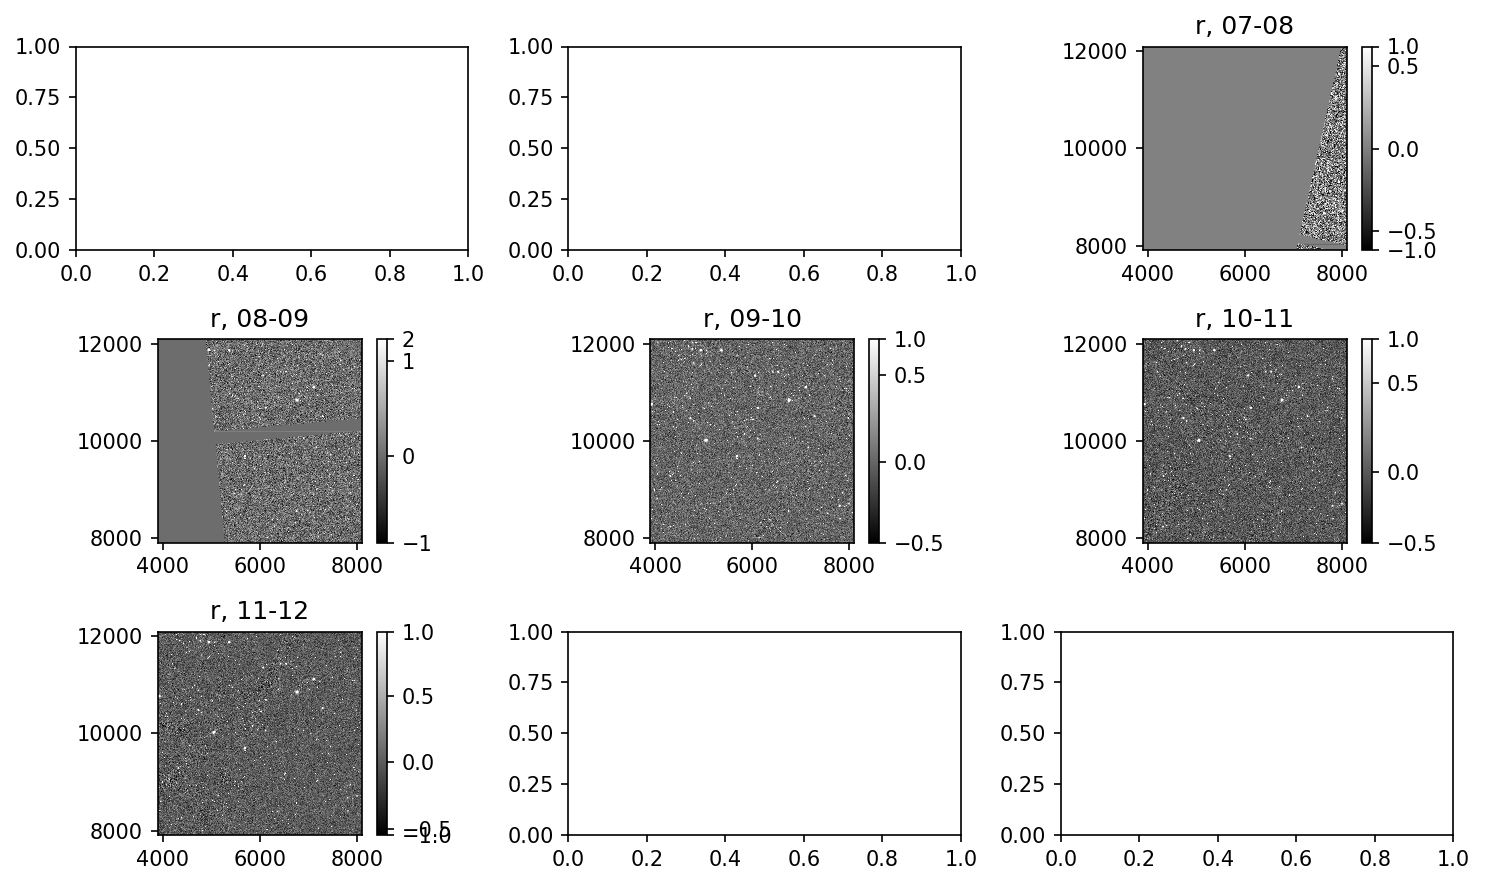

In [5]:
fig, ax = plt.subplots(3,3, figsize=(10, 6), dpi=150)
ax = ax.ravel()[:7]
coadd_to_use = []
collection_to_use = []
for i in range(len(dates_calexps_ym)-1):
    print(dates_calexps_ym['month'][i], dates_calexps_ym['month'][i+1])
    list_collections = butler.registry.queryCollections(f"u/taceroc_pm/*_t4026p15y2022_coadd*{dates_calexps_ym['month'][i]}-{dates_calexps_ym['month'][i+1]}*")
    my_outputCollection = list_collections[-1]
    collection_to_use.append(my_outputCollection)
    butler = Butler(repo, collections=my_outputCollection)
    coadd_list = list(butler.registry.queryDatasets('deepCoadd', where="tract = 4026 AND patch = 15 AND skymap = 'DC2' AND band = 'r' "))
    if len(coadd_list) >= 1:
        coadd_to_use.append(coadd_list[0])
        deepCoadd_test = butler.get(coadd_list[0])
        
        plt.sca(ax[i])
        display2 = afwDisplay.Display(frame=fig)
        display2.scale('linear', 'zscale')
        # display2.scale('linear', min=-20, max=150)
        display2.mtv(deepCoadd_test.image)
        plt.title(f"{coadd_list[0].dataId['band']}, {dates_calexps_ym['month'][i]}-{dates_calexps_ym['month'][i+1]}")
plt.tight_layout()
plt.show()

In [6]:
list_collections

['u/taceroc_pm/test_512025_1_t4026p15y2022_coadd_5282025_1_202211-12/20250528T180351Z',
 'u/taceroc_pm/test_512025_1_t4026p15y2022_coadd_5282025_1_202211-12']

In [7]:
coadd_to_use

[DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'r', skymap: 'DC2', tract: 4026, patch: 15}, run='u/taceroc_pm/test_512025_1_t4026p15y2022_coadd_592025_1_202207-08/20250509T170053Z', id=6615c369-9cde-40a3-9128-5024bf08e0e7),
 DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'r', skymap: 'DC2', tract: 4026, patch: 15}, run='u/taceroc_pm/test_512025_1_t4026p15y2022_coadd_592025_1_202208-09/20250509T195303Z', id=5175339e-8314-4e67-9859-9d285c27ae7c),
 DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'r', skymap: 'DC2', tract: 4026, patch: 15}, run='u/taceroc_pm/test_512025_1_t4026p15y2022_coadd_592025_1_202209-10/20250510T035101Z', id=29edea34-ed3e-4782-b59b-45c578caf98f),
 DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'r', skymap: 'DC2', tract: 4026, patch: 15}, run='u/taceroc_pm/test_512025_1_t4026p15y2022_coadd_5232025_1_202210-11/20250523

In [8]:
# # PATCH 7, 8, 9, 14, 16, 15, 17, 21, 22, 23
# for i in range(len(dates_calexps_ym)-1):
#     print(dates_calexps_ym['month'][i], dates_calexps_ym['month'][i+1])
#     list_collections = butler.registry.queryCollections(f"u/taceroc_pm/*_t4026p15y2022_coadd*{dates_calexps_ym['month'][i]}-{dates_calexps_ym['month'][i+1]}*")
#     my_outputCollection = list_collections[-1]
#     butler = Butler(repo, collections=my_outputCollection)
#     coadd_list = list(butler.registry.queryDatasets('deepCoadd', where="tract = 4026 AND patch = 15 AND skymap = 'DC2' AND band = 'r'"))
#     print(coadd_list)

In [9]:
# fig, ax = plt.subplots(3,3, figsize=(10, 6), dpi=150)
# ax = ax.ravel()[:7]
# coadd_to_use = []
# collection_to_use = []
# for ix,i in enumerate(range(2, len(dates_calexps_ym)-1)):
#     print(dates_calexps_ym['month'][i], dates_calexps_ym['month'][i+1])
#     list_collections = butler.registry.queryCollections(f"u/taceroc_pm/*_t4026p15y2022_coadd*{dates_calexps_ym['month'][i]}-{dates_calexps_ym['month'][i+1]}*")
#     my_outputCollection = list_collections[-1]
#     collection_to_use.append(my_outputCollection)
#     butler = Butler(repo, collections=my_outputCollection)
#     coadd_list = list(butler.registry.queryDatasets('deepCoadd', where="tract = 4026 AND patch = 15 AND skymap = 'DC2' AND band = 'r' "))
#     if len(coadd_list) >= 1:
        
#         coadd_to_use.append(coadd_list[0])
#         deepCoadd_test = butler.get(coadd_list[0])
        
#         plt.sca(ax[ix])
#         display2 = afwDisplay.Display(frame=fig)
#         display2.scale('linear', 'zscale')
#         # display2.scale('linear', min=-20, max=150)
#         display2.mtv(deepCoadd_test.image)
#         plt.title(f"{coadd_list[0].dataId['band']}, {dates_calexps_ym['month'][i]}-{dates_calexps_ym['month'][i+1]}")
# plt.tight_layout()
# plt.show()

In [10]:
# list_collections = butler.registry.queryCollections(f"u/taceroc_pm/*_t4026p15y2022_coadd*{dates_calexps_ym['month'][2]}-{dates_calexps_ym['month'][2+1]}*")
# my_outputCollection = list_collections[-1]
# collection_to_use.append(my_outputCollection)
# butler = Butler(repo, collections=my_outputCollection)
# coadd_list = list(butler.registry.queryDatasets('deepCoadd', where="tract = 4026 AND patch = 15 AND skymap = 'DC2' AND band = 'r' "))
# if len(coadd_list) >= 1:
#     coadd_to_use.append(coadd_list[0])
#     deepCoadd_test = butler.get(coadd_list[0])

In [11]:
# np.mean(deepCoadd_test.image.array)

In [12]:
# np.std(deepCoadd_test.image.array)

In [13]:
# plt.hist(np.log10(deepCoadd_test.image.array.flatten()))[0]

In [14]:
# np.mean(deepCoadd_test.image.array), np.std(deepCoadd_test.image.array)

In [15]:
# deepCoadd_test.image.array[deepCoadd_test.image.array <= (np.mean(deepCoadd_test.image.array) - np.std(deepCoadd_test.image.array))]

In [16]:
# plt.hist(np.log10(deepCoadd_test.image.array.flatten()), bins=40)[0]

# Load LEs simulations fits files

In [56]:
# list_fits = sorted(glob.glob("fits/4026_15/*220*.fits"))
# list_fits = sorted(glob.glob("fits/4026_15/*52000.0pc.fits"))
list_fits = sorted(glob.glob("fits/4026_15/ring/*52000.0pc.fits"))


In [55]:
list_fits

['fits/4026_15/ring_company/surface_valueslc2_InfPlane_dt0_loop_ct290_loc[0.9, 1.3, 1, -16.3078]_dz0.06_w567_angle[45, 60]_sourced52000.0pc.fits',
 'fits/4026_15/ring_company/surface_valueslc2_InfPlane_dt0_loop_ct365_loc[0.9, 1.3, 1, -16.3078]_dz0.06_w567_angle[45, 60]_sourced52000.0pc.fits',
 'fits/4026_15/ring_company/surface_valueslc2_InfPlane_dt0_loop_ct600_loc[0.9, 1.3, 1, -16.3078]_dz0.06_w567_angle[45, 60]_sourced52000.0pc.fits',
 'fits/4026_15/ring_company/surface_valueslc2_InfPlane_dt0_loop_ct690_loc[0.9, 1.3, 1, -16.3078]_dz0.06_w567_angle[45, 60]_sourced52000.0pc.fits',
 'fits/4026_15/ring_company/surface_valueslc2_InfPlane_dt0_loop_ct800_loc[0.9, 1.3, 1, -16.3078]_dz0.06_w567_angle[45, 60]_sourced52000.0pc.fits']

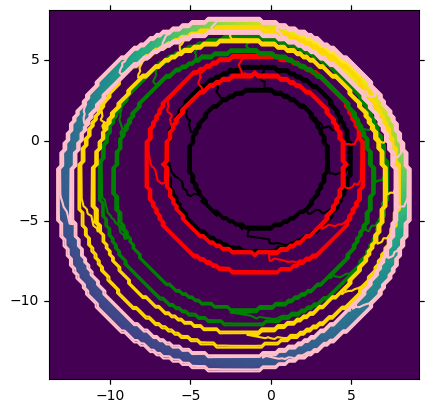

In [39]:
# hdu = fits.open(filename)[0]
stamp_img_hdu = fits.open(list_fits[-1])[0]
stamp_img_hdu0 = fits.open(list_fits[0])[0]
stamp_img_hdu1 = fits.open(list_fits[1])[0]
stamp_img_hdu2 = fits.open(list_fits[2])[0]
stamp_img_hdu3 = fits.open(list_fits[3])[0]
stamp_img_hdu4 = fits.open(list_fits[4])[0]
# stamp_img_hduwhole = fits.open(list_fits[0])[0]

fig, ax = plt.subplots(subplot_kw=dict(projection=WCS(stamp_img_hdu.header)))
ax.imshow(stamp_img_hdu.data, origin='lower')
ax.contour(stamp_img_hdu0.data, transform=ax.get_transform(WCS(stamp_img_hdu0.header)), colors='black')
ax.contour(stamp_img_hdu1.data, transform=ax.get_transform(WCS(stamp_img_hdu1.header)), colors='red')
ax.contour(stamp_img_hdu2.data, transform=ax.get_transform(WCS(stamp_img_hdu2.header)), colors='green')
ax.contour(stamp_img_hdu3.data, transform=ax.get_transform(WCS(stamp_img_hdu3.header)), colors='gold')
ax.contour(stamp_img_hdu4.data, transform=ax.get_transform(WCS(stamp_img_hdu4.header)), colors='pink')
# ax.contour(stamp_img_hduwhole.data, transform=ax.get_transform(WCS(stamp_img_hduwhole.header)), colors='grey')


In [40]:
stamp_img_hdu0.data.shape

(65, 65)

In [41]:
import pickle

# list_fits = sorted(glob.glob("fits/4026_15/*52000.0pc.fits"))
list_metadata = []
for lls in list_fits:
    edits = lls.replace(list_fits[0].split('surface')[0], 'lightecho_modeling_oop/OOP/results/LC_infplane_test_multi/arrays/')
    edits = edits.replace('surface_values', 'meta_info')
    edits = edits.replace('fits', 'pkl')
    list_metadata.append(edits)

list_metadata

['lightecho_modeling_oop/OOP/results/LC_infplane_test_multi/arrays/meta_infolc2_InfPlane_dt0_loop_ct290_loc[0.9, 1.3, 1, -16.3078]_dz0.06_w567_angle[0, 360]_sourced52000.0pc.pkl',
 'lightecho_modeling_oop/OOP/results/LC_infplane_test_multi/arrays/meta_infolc2_InfPlane_dt0_loop_ct365_loc[0.9, 1.3, 1, -16.3078]_dz0.06_w567_angle[0, 360]_sourced52000.0pc.pkl',
 'lightecho_modeling_oop/OOP/results/LC_infplane_test_multi/arrays/meta_infolc2_InfPlane_dt0_loop_ct600_loc[0.9, 1.3, 1, -16.3078]_dz0.06_w567_angle[0, 360]_sourced52000.0pc.pkl',
 'lightecho_modeling_oop/OOP/results/LC_infplane_test_multi/arrays/meta_infolc2_InfPlane_dt0_loop_ct690_loc[0.9, 1.3, 1, -16.3078]_dz0.06_w567_angle[0, 360]_sourced52000.0pc.pkl',
 'lightecho_modeling_oop/OOP/results/LC_infplane_test_multi/arrays/meta_infolc2_InfPlane_dt0_loop_ct800_loc[0.9, 1.3, 1, -16.3078]_dz0.06_w567_angle[0, 360]_sourced52000.0pc.pkl']

In [42]:
# with open(list_metadata[1], 'rb') as f:
#     meta_data = pickle.load(f)
# projection=WCS(stamp_img_hdu0.header)
# pixel_pos = projection.wcs_world2pix(meta_data[0]['act (arcsec)'], meta_data[0]['bct (arcsec)'],1)

In [43]:
# meta_data[0]

In [44]:
# pixel_pos

In [45]:
# projection.wcs_pix2world(*pixel_pos,1)

In [46]:
# pixel_pos = projection.wcs_world2pix(0,0,1)
# pixel_pos, projection.wcs_pix2world(*pixel_pos,1)

In [27]:
# fig, ax = plt.subplots(subplot_kw=dict(projection=WCS(stamp_img_hdu0.header)))
# ax.imshow(stamp_img_hduwhole.data, origin='lower')
# # ax.contour(stamp_img_hdu0.data, colors='black',origin='lower')
# # projection=WCS(stamp_img_hdu0.header)
# pixel_pos = projection.wcs_world2pix(0,0,1)
# ax.scatter(*pixel_pos)

# with open(list_metadata[1], 'rb') as f:
#     meta_data = pickle.load(f)
# projection=WCS(stamp_img_hdu0.header)
# pixel_pos = projection.wcs_world2pix(-meta_data[0]['act (arcsec)'], -meta_data[0]['bct (arcsec)'],1)
# ax.scatter(*pixel_pos, color='black', transform=ax.get_transform(WCS(stamp_img_hdu0.header)))

In [28]:
# meta_data[0]['act (arcsec)']/0.2, meta_data[0]['bct (arcsec)']/0.2

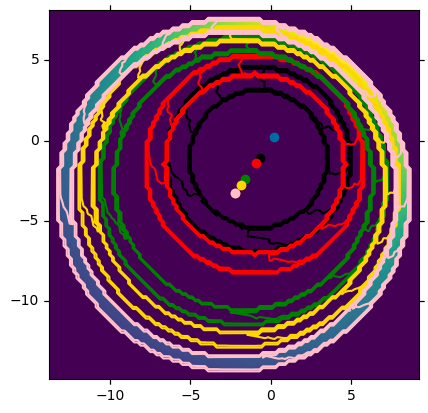

In [47]:
    
fig, ax = plt.subplots(subplot_kw=dict(projection=WCS(stamp_img_hdu.header)))
ax.imshow(stamp_img_hdu.data, origin='lower')
ax.contour(stamp_img_hdu0.data, transform=ax.get_transform(WCS(stamp_img_hdu0.header)), colors='black')
ax.contour(stamp_img_hdu1.data, transform=ax.get_transform(WCS(stamp_img_hdu1.header)), colors='red')
ax.contour(stamp_img_hdu2.data, transform=ax.get_transform(WCS(stamp_img_hdu2.header)), colors='green')
ax.contour(stamp_img_hdu3.data, transform=ax.get_transform(WCS(stamp_img_hdu3.header)), colors='gold')
ax.contour(stamp_img_hdu4.data, transform=ax.get_transform(WCS(stamp_img_hdu4.header)), colors='pink')
# ax.contour(stamp_img_hduwhole.data, transform=ax.get_transform(WCS(stamp_img_hduwhole.header)), colors='grey')

projection=WCS(stamp_img_hdu.header)
pixel_pos = projection.wcs_world2pix(0,0,1)
ax.scatter(*pixel_pos)

# list_metadata
with open(list_metadata[-1], 'rb') as f:
    meta_data = pickle.load(f)
projection=WCS(stamp_img_hdu.header)
pixel_pos = projection.wcs_world2pix(-meta_data[0]['act (arcsec)'], -meta_data[0]['bct (arcsec)'],1)
ax.scatter(pixel_pos[0], pixel_pos[1])

with open(list_metadata[0], 'rb') as f:
    meta_data = pickle.load(f)
projection=WCS(stamp_img_hdu0.header)
pixel_pos = projection.wcs_world2pix(-meta_data[0]['act (arcsec)'], -meta_data[0]['bct (arcsec)'],1)
ax.scatter(*pixel_pos, color='black', transform=ax.get_transform(WCS(stamp_img_hdu0.header)))

with open(list_metadata[1], 'rb') as f:
    meta_data = pickle.load(f)
projection=WCS(stamp_img_hdu1.header)
pixel_pos = projection.wcs_world2pix(-meta_data[0]['act (arcsec)'], -meta_data[0]['bct (arcsec)'],1)
ax.scatter(*pixel_pos, color='red', transform=ax.get_transform(WCS(stamp_img_hdu1.header)))


with open(list_metadata[2], 'rb') as f:
    meta_data = pickle.load(f)
projection=WCS(stamp_img_hdu2.header)
pixel_pos = projection.wcs_world2pix(-meta_data[0]['act (arcsec)'], -meta_data[0]['bct (arcsec)'],1)
ax.scatter(*pixel_pos, color='green', transform=ax.get_transform(WCS(stamp_img_hdu2.header)))

with open(list_metadata[3], 'rb') as f:
    meta_data = pickle.load(f)
projection=WCS(stamp_img_hdu3.header)
pixel_pos = projection.wcs_world2pix(-meta_data[0]['act (arcsec)'], -meta_data[0]['bct (arcsec)'],1)
ax.scatter(*pixel_pos, color='gold', transform=ax.get_transform(WCS(stamp_img_hdu3.header)))

with open(list_metadata[4], 'rb') as f:
    meta_data = pickle.load(f)
projection=WCS(stamp_img_hdu4.header)
pixel_pos = projection.wcs_world2pix(-meta_data[0]['act (arcsec)'], -meta_data[0]['bct (arcsec)'],1)
ax.scatter(*pixel_pos, color='pink', transform=ax.get_transform(WCS(stamp_img_hdu4.header)))


# Define injection catalog

In [48]:
ids_to_use_time = 3
coadd = butler.get(coadd_to_use[ids_to_use_time])
boxcen = coadd.getBBox().getCenter()
wcs_b = coadd.getWcs()
cen = wcs_b.pixelToSky(boxcen)
radec = SkyCoord(ra=cen[0].asDegrees()*u.deg, dec=cen[1].asDegrees()*u.deg)

print(radec)

imsize = coadd.getBBox().getDimensions()[0]*wcs_b.getPixelScale().asDegrees()
print('Size of calexp in degrees: ', imsize)

inject_size = imsize/2

<SkyCoord (ICRS): (ra, dec) in deg
    (57.85714959, -35.17965612)>
Size of calexp in degrees:  0.23333333327427816


In [49]:
coadd.getBBox().getDimensions()[0]*wcs_b.getPixelScale().asDegrees()/coadd.getBBox().getDimensions()[0]

5.55555555414948e-05

In [50]:
5.55555555414948e-05*10

0.000555555555414948

## 1st image

In [51]:
ids_to_use_time_fits = 1 #ids_to_use_time
which_fits = list_fits[ids_to_use_time_fits]
fits_img = fits.open(which_fits)[0].data
mags_plot = -2.5*np.log10(fits_img)-48.6
mags_plot = np.nan_to_num(mags_plot, nan=0.0, posinf=0.0, neginf=0.0)
ns = imsize/((mags_plot.shape[0])*wcs_b.getPixelScale().asDegrees())
Ns = int((ns*ns) - 10)
if Ns > 20:
    Ns = 20
print("mean surface", np.mean(mags_plot[fits_img>0]))

mean surface 21.36420668142356


/tmp/ipykernel_2235597/96053701.py:4: RuntimeWarning: divide by zero encountered in log10
  mags_plot = -2.5*np.log10(fits_img)-48.6


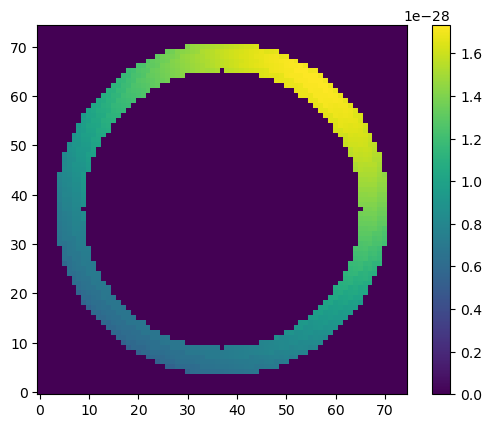

In [53]:
plt.imshow(fits_img, origin='lower')
plt.colorbar()

mean surface 1.1328727493781807


/tmp/ipykernel_2235597/3923975746.py:5: RuntimeWarning: divide by zero encountered in log10
  mags_plot = -2.5*np.log10(fits_img_2nd)-48.6


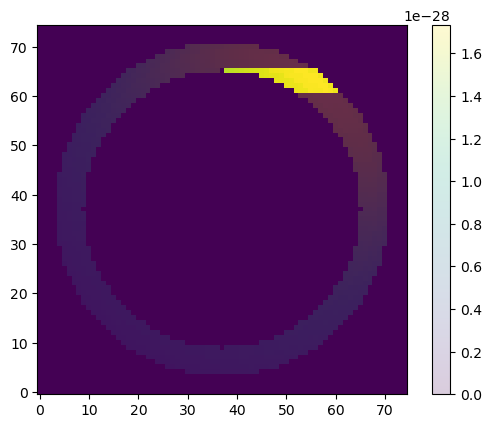

In [60]:
list_fits = sorted(glob.glob("fits/4026_15/ring_company/*52000.0pc.fits"))
ids_to_use_time_fits = 1 #ids_to_use_time
which_fits_2nd = list_fits[ids_to_use_time_fits]
fits_img_2nd = fits.open(which_fits_2nd)[0].data
mags_plot = -2.5*np.log10(fits_img_2nd)-48.6
mags_plot = np.nan_to_num(mags_plot, nan=0.0, posinf=0.0, neginf=0.0)
ns = imsize/((mags_plot.shape[0])*wcs_b.getPixelScale().asDegrees())
Ns = int((ns*ns) - 10)
if Ns > 20:
    Ns = 20
print("mean surface", np.mean(mags_plot[fits_img>0]))
plt.imshow(fits_img_2nd, origin='lower')
plt.imshow(fits_img, origin='lower', alpha=0.2)

plt.colorbar()

In [23]:
with open(list_metadata[ids_to_use_time], 'rb') as f:
    meta_data = pickle.load(f)

In [24]:
meta_data

[{'r_in (arcsec)': array([10.41236192, 10.4122099 , 10.41205742, ...,  7.82604196,
          7.82595034,  7.82585859]),
  'r_out (arcsec)': array([10.47370484, 10.47370484, 10.47370484, ...,  7.87412639,
          7.87412639,  7.87412639]),
  'act (arcsec)': 2.069191943591003,
  'bct (arcsec)': 2.9888328074092265,
  'params': [0.9, 1.3, 1, -16.3078],
  'dz0 (ly)': 0.19569359999999997,
  'source distance (ly)': 169601.12,
  'ct (days)': 690,
  'wavelength': 0.567}]

In [25]:
resx = coadd.getBBox().getDimensions()[0]*wcs_b.getPixelScale().asDegrees()/coadd.getBBox().getDimensions()[0]
resy= coadd.getBBox().getDimensions()[1]*wcs_b.getPixelScale().asDegrees()/coadd.getBBox().getDimensions()[1]
resx, resy

(5.55555555414948e-05, 5.55555555414948e-05)

In [26]:
center_shift = [resx*(meta_data[0]['act (arcsec)']/0.2), resy*(meta_data[0]['bct (arcsec)']/0.2)]

In [27]:
center_shift

[0.0005747755397409177, 0.0008302313351813255]

## 2nd image

In [63]:
ids_to_use_time = 4
coadd = butler.get(coadd_to_use[ids_to_use_time])
boxcen = coadd.getBBox().getCenter()
wcs_b = coadd.getWcs()
cen = wcs_b.pixelToSky(boxcen)
radec = SkyCoord(ra=cen[0].asDegrees()*u.deg, dec=cen[1].asDegrees()*u.deg)

print(radec)

imsize = coadd.getBBox().getDimensions()[0]*wcs_b.getPixelScale().asDegrees()
print('Size of calexp in degrees: ', imsize)

inject_size = imsize/2


ids_to_use_time_fits = 2 #ids_to_use_time
which_fits = list_fits[ids_to_use_time_fits]
fits_img = fits.open(which_fits)[0].data
mags_plot = -2.5*np.log10(fits_img)-48.6
mags_plot = np.nan_to_num(mags_plot, nan=0.0, posinf=0.0, neginf=0.0)
print("mean surface", np.mean(mags_plot[fits_img>0]))



<SkyCoord (ICRS): (ra, dec) in deg
    (57.85714959, -35.17965612)>
Size of calexp in degrees:  0.23333333327427816
mean surface 21.38767757742151


/tmp/ipykernel_282546/592419661.py:19: RuntimeWarning: divide by zero encountered in log10
  mags_plot = -2.5*np.log10(fits_img)-48.6


# Inject on image